In [ ]:
!pip install rasterio torch torchvision numpy matplotlib tqdm

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import rasterio
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cpu


In [ ]:
import kagglehub

path = kagglehub.dataset_download("sachingiri348/aviris-ng-hyperspectral-data")
print("Dataset downloaded at:", path)


Using Colab cache for faster access to the 'aviris-ng-hyperspectral-data' dataset.
Dataset downloaded at: /kaggle/input/aviris-ng-hyperspectral-data


In [ ]:
import os

DATA_DIR = None

for root, dirs, files in os.walk(path):
    for f in files:
        if f.endswith(".tif"):
            DATA_DIR = root
            break
    if DATA_DIR:
        break

print("Detected TIFF folder:", DATA_DIR)

files = [f for f in os.listdir(DATA_DIR) if f.endswith(".tif")]
print("Total images:", len(files))
print("Sample files:", files[:5])


Detected TIFF folder: /kaggle/input/aviris-ng-hyperspectral-data/AVIRIS-NG-8-bands/test/hyper
Total images: 6
Sample files: ['ang20191023t162847_r7610_c492_w151_h151.tif', 'ang20191023t162847_r9887_c159_w151_h151.tif', 'ang20191023t152801_r9013_c303_w151_h151.tif', 'ang20191023t151141_r9205_c186_w151_h151.tif', 'ang20191023t151141_r9647_c396_w151_h151.tif']


In [ ]:
DATA_DIR = "/root/.cache/kagglehub/datasets/sachingiri348/aviris-ng-hyperspectral-data/versions/1/AVIRIS-NG-8-bands/train/multi"

files = [f for f in os.listdir(DATA_DIR) if f.endswith(".tif")]
print("Total images:", len(files))


Total images: 50


In [ ]:
##def load_image(file_path):
    ##with rasterio.open(file_path) as src:
        #img = src.read().astype(np.float32)  # (bands, H, W)
       #img = np.transpose(img, (1,2,0))     # (H, W, bands)
        #img = (img - img.min()) / (img.max() - img.min() + 1e-6)
        #return img


In [ ]:
def rx_detector(image_hw):

    H, W, C = image_hw.shape
    X = image_hw.reshape(-1, C)

    mu = np.mean(X, axis=0)
    cov = np.cov(X, rowvar=False)
    cov_inv = np.linalg.pinv(cov)

    diff = X - mu
    rx_scores = np.sum(diff @ cov_inv * diff, axis=1)

    rx_map = rx_scores.reshape(H, W)
    rx_map = (rx_map - rx_map.min()) / (rx_map.max() - rx_map.min() + 1e-6)
    return rx_map


In [ ]:
def create_rx_label(image_hw):
    rx_map = rx_detector(image_hw)
    threshold = np.percentile(rx_map, 99)
    mask = (rx_map > threshold).astype(np.float32)
    return mask


In [ ]:
class AVIRISDatasetRX(Dataset):
    def __init__(self, data_dir):
        self.files = [os.path.join(data_dir, f)
                      for f in os.listdir(data_dir)
                      if f.endswith(".tif")]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        with rasterio.open(self.files[idx]) as src:
            image = src.read().astype(np.float32)  # (C, H, W) → here C=3

        # Normalize
        image = (image - image.min()) / (image.max() - image.min() + 1e-6)

        # RX label needs H,W,C
        image_hw = np.transpose(image, (1,2,0))
        mask = create_rx_label(image_hw)

        image = torch.tensor(image, dtype=torch.float32)        # (3, H, W)
        mask  = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # (1, H, W)

        return image, mask


In [ ]:
dataset = AVIRISDatasetRX(DATA_DIR)

train_size = int(0.8 * len(dataset))
val_size   = len(dataset) - train_size

train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=4)

# Sanity check
img, mask = dataset[0]
print("Image shape:", img.shape)
print("Mask shape:", mask.shape)


Image shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([1, 512, 512])


In [ ]:
img, mask = dataset[0]
print("Image shape:", img.shape)
print("Mask shape:", mask.shape)


Image shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([1, 512, 512])


In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )

    def forward(self, x):
        return self.net(x)


class UNetPro(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.dec4 = DoubleConv(512 + 256, 256)
        self.dec3 = DoubleConv(256 + 128, 128)
        self.dec2 = DoubleConv(128 + 64, 64)

        self.up  = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.out = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        d4 = self.dec4(torch.cat([self.up(e4), e3], dim=1))
        d3 = self.dec3(torch.cat([self.up(d4), e2], dim=1))
        d2 = self.dec2(torch.cat([self.up(d3), e1], dim=1))

        return torch.sigmoid(self.out(d2))


In [ ]:
class DiceLoss(nn.Module):
    def forward(self, pred, target):
        smooth = 1e-6
        intersection = (pred * target).sum()
        union = pred.sum() + target.sum()
        return 1 - (2 * intersection + smooth) / (union + smooth)

class HybridLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce  = nn.BCELoss()
        self.dice = DiceLoss()

    def forward(self, pred, target):
        return self.bce(pred, target) + self.dice(pred, target)


In [ ]:
for img, _ in train_loader:
    print(img.shape)
    break


torch.Size([4, 3, 512, 512])


In [19]:
model = UNetPro(in_channels=3).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
loss_fn   = HybridLoss()

EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    for img, mask in tqdm(train_loader):
        img, mask = img.to(device), mask.to(device)

        pred = model(img)
        loss = loss_fn(pred, mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}  Loss: {epoch_loss/len(train_loader):.4f}")


100%|██████████| 10/10 [17:36<00:00, 105.67s/it]


Epoch 1/10  Loss: 1.6430


100%|██████████| 10/10 [17:24<00:00, 104.41s/it]


Epoch 2/10  Loss: 1.4682


100%|██████████| 10/10 [17:13<00:00, 103.31s/it]


Epoch 3/10  Loss: 1.4249


100%|██████████| 10/10 [17:13<00:00, 103.31s/it]


Epoch 4/10  Loss: 1.4014


100%|██████████| 10/10 [17:01<00:00, 102.15s/it]


Epoch 5/10  Loss: 1.3851


100%|██████████| 10/10 [17:02<00:00, 102.30s/it]


Epoch 6/10  Loss: 1.3544


100%|██████████| 10/10 [17:00<00:00, 102.04s/it]


Epoch 7/10  Loss: 1.3403


100%|██████████| 10/10 [17:00<00:00, 102.02s/it]


Epoch 8/10  Loss: 1.3059


100%|██████████| 10/10 [17:00<00:00, 102.04s/it]


Epoch 9/10  Loss: 1.3011


100%|██████████| 10/10 [17:00<00:00, 102.08s/it]

Epoch 10/10  Loss: 1.2772


In [23]:
torch.save(model.state_dict(), "unet_rx_3band.pth")
print("Model saved as unet_rx_3band.pth")


Model saved as unet_rx_3band.pth


In [25]:
import rasterio
import numpy as np

def load_image(file_path):
    with rasterio.open(file_path) as src:
        img = src.read().astype(np.float32)   # (C, H, W)
        img = np.transpose(img, (1,2,0))      # (H, W, C)
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)
        return img


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


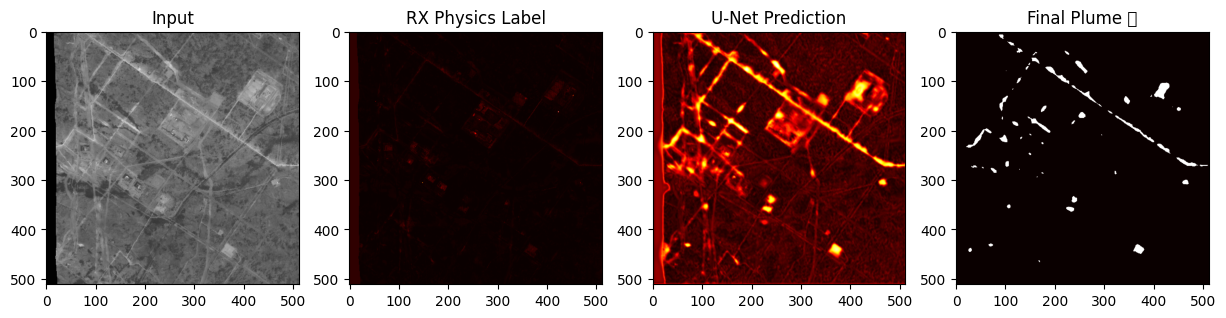

In [26]:
model.eval()

sample_file = random.choice(files)
image = load_image(os.path.join(DATA_DIR, sample_file))
rx_map = rx_detector(image)

img_tensor = torch.tensor(image).permute(2,0,1).unsqueeze(0).to(device)

with torch.no_grad():
    pred = model(img_tensor).cpu().squeeze().numpy()

threshold = np.percentile(pred, 98)
mask = pred > threshold

plt.figure(figsize=(15,4))

plt.subplot(1,4,1)
plt.title("Input")
plt.imshow(image[:,:,0], cmap="gray")

plt.subplot(1,4,2)
plt.title("RX Physics Label")
plt.imshow(rx_map, cmap="hot")

plt.subplot(1,4,3)
plt.title("U-Net Prediction")
plt.imshow(pred, cmap="hot")

plt.subplot(1,4,4)
plt.title("Final Plume 🔴")
plt.imshow(mask, cmap="hot")

plt.show()
